## Импорты

In [1]:
import pandas as pd
import numpy as np
import sklearn
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sbn


from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import KFold
from sklearn.preprocessing import Imputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# from user_agents import parse

import datetime

from sklearn.tree import DecisionTreeClassifier
from sklearn import grid_search
from sklearn import tree

from sklearn import grid_search
from sklearn.tree import _tree

from sklearn.tree import export_graphviz

import dateutil.parser

import matplotlib.dates as mdates

import json
import io

import graphviz

import locale
locale.setlocale(locale.LC_ALL, '')

%pylab inline

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Populating the interactive namespace from numpy and matplotlib


## Объявления полезных функций

In [2]:
def log_mes(mes):
    """Выводит таймстемп и переданное сообщение"""
    print(datetime.datetime.now().strftime("%H:%M:%S %d.%m.%Y"), mes)

In [3]:
def plot_roc_curve(y, y_pred, color, name):
    fpr_moscow, tpr_moscow, _ = roc_curve(y, y_pred[:, 1])
    roc_auc = roc_auc_score(y, y_pred[:, 1])
    plt.plot(fpr_moscow, tpr_moscow, color=color, lw=2, label='{0} {1:n} samples (AUC = {2:0.4f})'\
             .format(name, len(y), roc_auc))

    plt.ylim([0, 1])
    plt.xlim([0, 1])
    plt.xticks(arange(6)/5)
    plt.yticks(arange(6)/5)
    plt.grid(linestyle='-')
    
    plt.xlabel('False positive')
    plt.ylabel('True positive')
    plt.legend(loc=4, prop={'size': 20})

In [4]:
def plot_precision_recall(fig, y_test, y_pred, title, i, n):
    subplot = fig.add_subplot(n,1,i)
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred[:,1])
    plt.step(recall, precision, color='blue', lw=1)
    plt.fill_between(recall, precision, step='pre', alpha=0.2, color='blue')
    plt.ylim([0, 1])
    plt.xlim([0, 1])

    subplot.yaxis.grid()
    subplot.xaxis.grid()
    subplot.set_xticklabels([])
    subplot.set_title(title)

## 1. Чтение выгрузки

In [5]:
metabase_unload = pd.read_csv('unloads/unload.csv', delimiter=",")

In [6]:
# Юзер-агент пока не использую, т.к. он очень долго анализируется
# metabase_unload['device'] = metabase_unload.apply(lambda x: parse(x['user_agent']).device if pd.isnull(x['user_agent']) == False else "None", axis=1)
# metabase_unload['os_version'] = metabase_unload.apply(lambda x: parse(x['user_agent']).os.version if pd.isnull(x['user_agent']) == False else "None", axis=1)
columns_to_drop = ['user_agent', 'school_id', 'address_entered_before_payment']
metabase_unload = metabase_unload.drop(columns_to_drop, axis=1)

In [7]:
metabase_unload["sign_up_date"] = metabase_unload.apply(lambda x: datetime.datetime.fromtimestamp(x['sign_up_date']), axis=1)

In [8]:
metabase_unload.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 510670 entries, 0 to 510669
Data columns (total 20 columns):
user_id                        510670 non-null int64
first_name                     510669 non-null object
sign_up_date                   510670 non-null datetime64[ns]
first_payment_date             27293 non-null object
paid_on_day_since_sign_up      27293 non-null float64
reg_page                       418880 non-null object
reason                         47690 non-null float64
teacher                        47690 non-null float64
time                           47690 non-null float64
best_statement                 47690 non-null float64
signed_up_on_weekend_day       510670 non-null int64
signed_up_at_night_interval    510670 non-null int64
source_group_id                510670 non-null int64
grade_id                       510670 non-null int64
has_birth_date                 510670 non-null int64
is_parent                      510670 non-null int64
is_teacher               

### Определим пол клиента по имени

In [9]:
# Загружаем предварительно созданные файлы с именами
with io.open('unloads/names_w.json', 'r', encoding='utf8') as outfile:
    names_w = json.load(outfile)
with io.open('unloads/names_m.json', 'r', encoding='utf8') as outfile:
    names_m = json.load(outfile)

In [10]:
n_w = ( (item['first_form'], 0) for item in names_w )
n_m = ( (item['first_form'], 1) for item in names_m )
column_names = ['first_name', 'gender']

names_df = pd.DataFrame(n_w, columns=column_names).append(pd.DataFrame(n_m, columns=column_names))

In [11]:
metabase_unload['first_name'] = metabase_unload\
    .apply(lambda row: str(row['first_name']).strip().lower().replace('ё', 'е').split(', '), axis=1)

In [12]:
metabase_unload = metabase_unload.merge(names_df, how='left', on='first_name').drop('first_name', axis=1)

In [13]:
metabase_unload.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 511007 entries, 0 to 511006
Data columns (total 20 columns):
user_id                        511007 non-null int64
sign_up_date                   511007 non-null datetime64[ns]
first_payment_date             27293 non-null object
paid_on_day_since_sign_up      27293 non-null float64
reg_page                       419144 non-null object
reason                         47728 non-null float64
teacher                        47728 non-null float64
time                           47728 non-null float64
best_statement                 47728 non-null float64
signed_up_on_weekend_day       511007 non-null int64
signed_up_at_night_interval    511007 non-null int64
source_group_id                511007 non-null int64
grade_id                       511007 non-null int64
has_birth_date                 511007 non-null int64
is_parent                      511007 non-null int64
is_teacher                     511007 non-null int64
has_phone                 

Удалось определить пол у 428492 клиентов из 528355

## 2. Создание модели

In [14]:
woe_columns = ['reg_page']
category_columns = ['grade_id', 'source_group_id', 'reason', 'teacher', 'time', 'best_statement', 'region_id']
columns_to_drop = ['user_id', 'sign_up_date', 'paid_on_day_since_sign_up', 'first_payment_date']

In [15]:
def copy_dataset_and_create_target_variable(df, target_column_name, has_paid_in_X_days):
    """
    Copies dataset and creates in new dataset binary variable, which contains true if client 
    paid in X days after sign up and false otherwise.
    """
    df_new = df.copy()
    df_new[target_column] = df_new.apply(lambda x: 1 if x['paid_on_day_since_sign_up'] <= has_paid_in_X_days else 0, axis=1)
    return df_new

In [16]:
class Model:
    def __init__(self, target_variable, woe_columns, category_columns, columns_to_drop, classifier):
        self._init_values()
        
        self._target_variable = target_variable
        self._woe_columns = woe_columns.copy()
        self._category_columns = category_columns.copy()
        self._columns_to_drop = columns_to_drop.copy()
        
        self._classifier = classifier
        
        
    def fit(self, X_train, y_train):
        """
        1. Counts woe's 
        2. Binarizes category columns
        3. Fits classifier
        """
        self._model_has_been_fit = False
        self._init_values()
        self._X_train = X_train.copy()
        self._y_train = y_train.copy()
        self._count_all_woe()
        self._fit_classifier()
        self._model_has_been_fit = True
        return self
        
    def _init_values(self):
        self._woe_dataframes = {}
        self._model_has_been_fit = False
        
    
    def predict_proba(self, X_test):
        """
        Predicts probability of target column
        """
        if not self._model_has_been_fit:
            raise RuntimeError("Model has not been fit. Prediction is impossible.")
            
        self._X_test = X_test
        return self._predict_proba()
        
        
    def plot_importance(self, importance_type='weight'):
        """
        Plots XGBoost feature importance
        """
        if not self._model_has_been_fit:
            raise RuntimeError("Model has not been fit. Plotting is impossible.")

        fig, ax = plt.subplots(1,1,figsize=(15, 10))
        return xgb.plot_importance(booster=self._model, ax=ax, importance_type=importance_type)
    
    
    def get_feature_names(self):
        return self._X_train.columns
    
   
    def _fit_classifier(self):
        self._weights = self._count_weights(self._X_train)
        self._X_train = self._transform_dataframe(self._X_train)
        self._fit_imputer(self._X_train)
        
        X_train = pd.DataFrame(self._impute(self._X_train), columns=self._X_train.columns)
        
        self._classifier.fit(X_train, self._y_train, sample_weight=self._weights)
          
        
    def _count_weights(self, X):
        paid_size = X[self._target_variable].value_counts(dropna=False)[1]
        not_paid_size = X[self._target_variable].value_counts(dropna=False)[0]
        
        paid_weight = not_paid_size/paid_size
        
        return list(X.apply(lambda row: 1 if row[self._target_variable] == 0 else paid_weight, axis=1))
       
        
    def _predict_proba(self):
        self._X_test = self._transform_dataframe(self._X_test)
        self._X_test = self._match_train_and_test_columns(self._X_train, self._X_test)
        X_test = pd.DataFrame(self._impute(self._X_test), columns=self._X_test.columns)
        
        return self._classifier.predict_proba(X_test)

    
    def _count_all_woe(self):
        # Считаем woe-колонки
        for column in self._woe_columns:
            self._count_woe(column)
    
    
    def _transform_dataframe(self, X):
        X = self._join_woe(X)
        X = self._drop_not_features(X)
        X = self._binarize_category_cols(X)

        return X
    
    
    def _fit_imputer(self, X):
        self._imputer = Imputer(missing_values=NaN, strategy='median', axis=0)
        self._imputer.fit(X)
    
    
    def _impute(self, X):
        return self._imputer.transform(X)
    
    
    def _drop_not_features(self, X):
        if not self._target_variable in self._columns_to_drop:
            self._columns_to_drop.append(self._target_variable)
        
        return X.drop(self._columns_to_drop, axis = 1)
    
    
    def _binarize_category_cols(self, X):
        return pd.get_dummies(X, columns=self._category_columns, drop_first=True)
    
    
    def _match_train_and_test_columns(self, X_train, X_test):
        columns_to_drop = []
        for column in X_test.columns:
            if column not in X_train.columns:
                columns_to_drop.append(column)
        X_test.drop(columns_to_drop, axis=1)
        
        for column in X_train.columns:
            if column not in X_test.columns:
                X_test[column] = pd.Series(index=X_test.index, dtype=X_train.dtypes[column])
        
        X_test = X_test[X_train.columns]
        
        return X_test
        
        
    def _count_woe(self, column_name):
        """
        Counts woe for passed column name in train dataset.
        Result stores in self._woe_dataframes
        """
        threshold = 100

        # расчет общего количества положительных и отрицательных событий
        paid_size = len(self._X_train[self._X_train[self._target_variable] == 1])
        not_paid_size = len(self._X_train[self._X_train[self._target_variable] == 0])

        # имя колонки, в которую будет помещен результат расчета
        woe_column_name = column_name + '_woe'
        
        # незаполненные значения должны учитываться как отдельная категория
        self._X_train[column_name] = self._X_train[column_name].astype(object)
        self._X_train[column_name] = self._X_train[column_name].fillna('__na__filler__')
        
        # расчет общего количества пользователей и количества положительных событий для каждой категории
        woe_ds = self._X_train\
            .groupby([column_name])\
            .agg({'user_id':'size', self._target_variable:'sum'})\
            .reset_index()\
            .rename(columns={'user_id':'total'})

        # отсекаем категории, в которых количество пользователей не превышает 100 и категории, 
        # в которых нет ни одного положительного события
        woe_ds = woe_ds[(woe_ds['total'] > threshold) & (woe_ds[self._target_variable] > 0)]

        # расчитываем количество отрицательных событий для каждой из категорий
        woe_ds['has_not_paid'] = woe_ds.apply(lambda x: x.total - x[self._target_variable], axis=1)

        # рассчитываем WOE
        woe_ds["woe_value"] = woe_ds\
            .apply(lambda x: math.log((x[self._target_variable]/paid_size)/(x.has_not_paid/not_paid_size)), axis=1)

        # удаляем промежуточные колонки для расчета
        woe_ds = woe_ds.drop([self._target_variable, 'has_not_paid', 'total'], axis=1)

        self._woe_dataframes[column_name] = woe_ds
         
            
    def _join_woe(self, X):
        """
        Joins woe from self._woe_dataframes to passed dataset
        """
        for column_name, woe_df in self._woe_dataframes.items():
            woe_column_name = column_name + '_woe'
            
            # джоиним woe
            rename = {'woe_value': woe_column_name}
            X = X.merge(woe_df.rename(columns=rename), how='left', left_on=column_name, right_on=column_name)
            
            # удаляем старую категориальную колонку
            X = X.drop(column_name, axis=1)
            
            # заполняем незаполненные значения медианами
            median = np.median(X[woe_column_name].dropna())
            X[woe_column_name] = X[woe_column_name].fillna(median)

        return X

## 3. Запуск и анализ результатов модели на всей выборке со случайным разделением на тренировочную и тестовую выборку

### 3.1. Сформируем целевую переменную и случайный тестовый набор данных

In [17]:
target_column = 'has_paid_in_X_days_after_sign_up'

# Выделяем целевую переменную
X = copy_dataset_and_create_target_variable(metabase_unload, target_column, 30)
y = X[target_column]

# Делим на train и test
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.2, random_state=42)

### 3.2. Выберем модель
Оценим 3 модели: RandomForestClassifier, XGBClassifier, DecisionTreeClassifier(max_depth=10)
Для оценки применим кросс-валидацию

In [18]:
def validation_pipeline(X, y, classifiers, splits=4, shuffle=False, random_state=None):
    """
    Doing cross-validation
    """
    # строим кросс-валидацию
    kfold = KFold(n_splits=splits,shuffle=shuffle,random_state=random_state)
    
    log_mes('Validation begins')
    
    for classifier in classifiers:
        log_mes('Validating "' + str(classifier) + '":')
        
        # обходим получившиеся сэмплы
        s_num = 1
        for train_index, test_index in kfold.split(X):
            # создаем сэмплы для теста и трейна
            X_train = X.loc[train_index]
            X_test = X.loc[test_index]
            y_train, y_test = y[train_index], y[test_index]
            
            fit_begin = datetime.datetime.now()
            
            # создаем и обучаем модель
            model = Model(target_column, woe_columns, category_columns, columns_to_drop, classifier)
            model.fit(X_train, y_train)

            # делаем предсказание
            y_test_pred = model.predict_proba(X_test)

            time_spent = (datetime.datetime.now() - fit_begin).total_seconds()
            
            # считаем roc-auc
            roc_auc_test = roc_auc_score(y_test, y_test_pred[:,1])
            log_mes('\tSample {0}. AUC = {1}. Time spent: {2}'.format(s_num, roc_auc_test, time_spent))
            
            s_num += 1
        
    log_mes('Validation finished')

In [19]:
classifiers = [RandomForestClassifier(), xgb.XGBClassifier(), DecisionTreeClassifier(max_depth=10)]

validation_pipeline(X, y, classifiers, splits=4, shuffle=False, random_state=42)

02:12:20 17.12.2017 Validation begins
02:12:20 17.12.2017 Validating "RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)":
02:13:18 17.12.2017 	Sample 1. AUC = 0.78714596886692. Time spent: 57.760992
02:14:13 17.12.2017 	Sample 2. AUC = 0.8541362550131741. Time spent: 54.692242
02:15:10 17.12.2017 	Sample 3. AUC = 0.7886115214513154. Time spent: 57.443628
02:16:11 17.12.2017 	Sample 4. AUC = 0.8575362803750506. Time spent: 60.939854
02:16:11 17.12.2017 Validating "XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=

**RandomForestClassifier** показал худшие результаты.<br/>
**XGBClassifier** показал лучшие результаты, но и самое большое время работы.<br/>
**DecisionTreeClassifier(max_depth=10)** показал удовлетворительные результаты и лучшее время работы. Кроме того результаты работы этого классификатора легко интерпретировать.<br/>
<br/>
Выберем XGBClassifier

### 3.3. Обучим модель и сделаем предсказание

In [20]:
classifier = xgb.XGBClassifier()

model_random = Model(target_column, woe_columns, category_columns, columns_to_drop, classifier)
model_random.fit(X_train, y_train)

y_test_pred = model_random.predict_proba(X_test)
y_train_pred = model_random.predict_proba(X_train)

### 3.4. Выведем результаты на roc-кривую

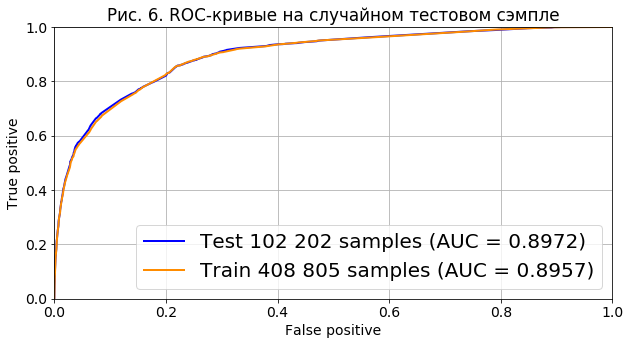

In [21]:
fig = plt.figure(figsize=(10, 5))
fig.patch.set_facecolor('white')
mpl.rcParams['font.size'] = 14
plt.title("Рис. 6. ROC-кривые на случайном тестовом сэмпле")

plot_roc_curve(y_test, y_test_pred, 'blue', 'Test')
plot_roc_curve(y_train, y_train_pred, 'darkorange', 'Train')

### 3.5. Выведем результаты на кривую Precision-Recall

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


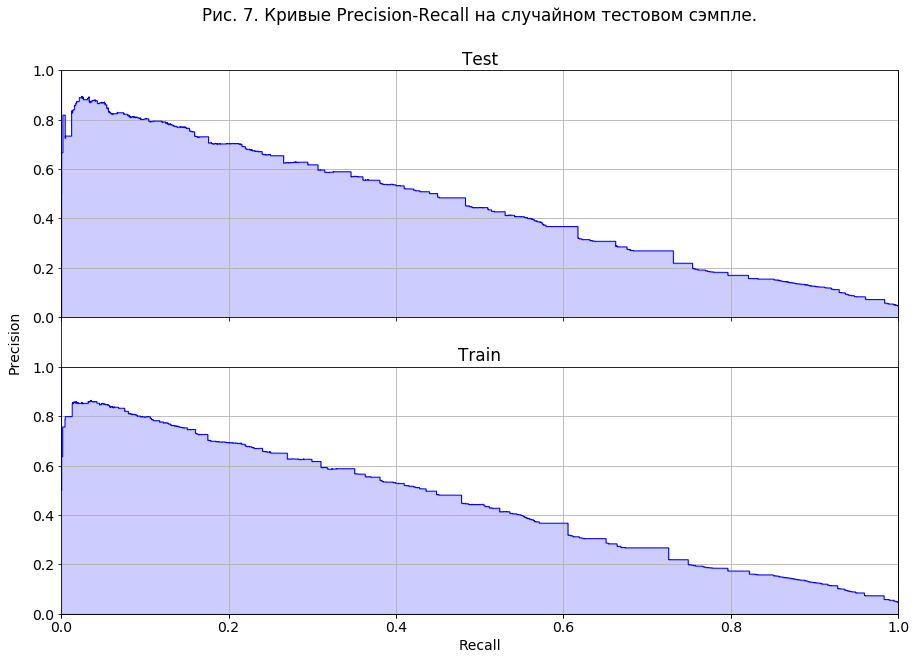

In [22]:
fig = plt.figure(figsize=[15, 10])
fig.patch.set_facecolor('white')
plt.title("Рис. 7. Кривые Precision-Recall на случайном тестовом сэмпле.", y=1.08)
mpl.rcParams['font.size'] = 14

ax = plt.axes()
ax.set_yticks([])
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')
ax.yaxis.labelpad = 40

plot_precision_recall(fig, y_test, y_test_pred, 'Test', 1, 2)
plot_precision_recall(fig, y_train, y_train_pred, 'Train', 2, 2)



### 3.6 Важность фич

Text(0.5,1,'Рис 13. Важность признаков по XGBoostClassifier.')

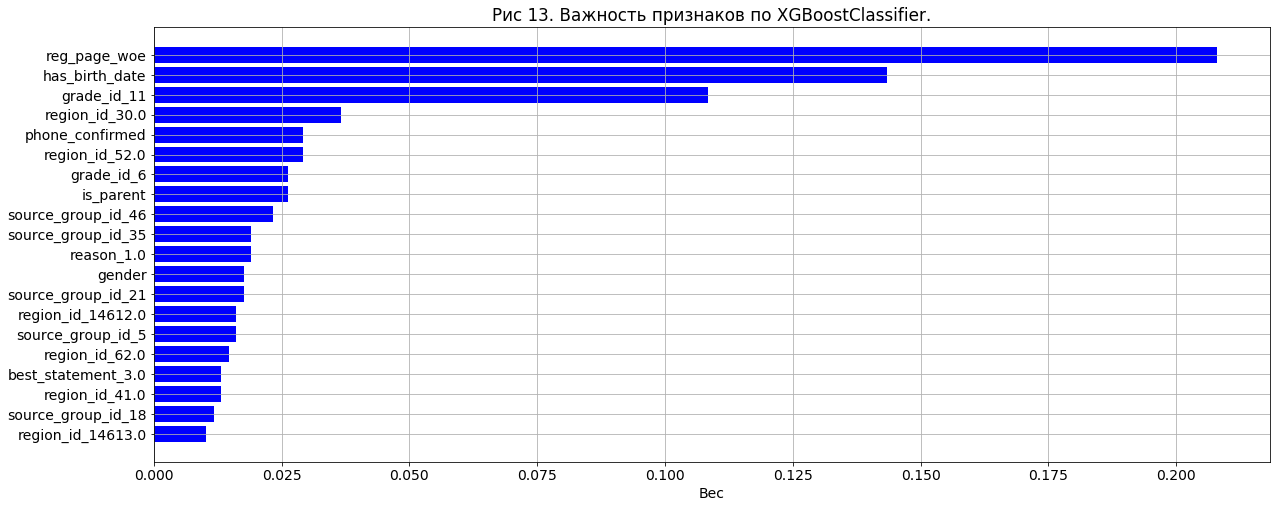

In [23]:
max_features = 20

importance = pd.DataFrame({'importance' : classifier.feature_importances_, 'feature_name' : model_random._X_train.columns})
importance = importance.sort_values(['importance'], ascending=False).head(max_features)

y_pos = np.arange(max_features)
fig = plt.figure(figsize=(20,8))
fig.patch.set_facecolor('white')

mpl.rcParams['font.size'] = 14

ax1 = fig.gca()
ax1.barh(y_pos, importance['importance'], color='b')
ax1.set_yticks(y_pos)
ax1.set_yticklabels(importance['feature_name'])
ax1.invert_yaxis()
ax1.grid()
ax1.set_xlabel('Вес')
ax1.set_title('Рис 13. Важность признаков по XGBoostClassifier.')

### 3.7. Промежуточные итоги
Модель показывает устойчивые результаты на всей выборке. Roc-кривая и кривая precision-recall говорят о хорошей вероятности предсказания целевого события. <br>
Наиболее важные признаки для XGBoost: страница регистрации, регион и канал продвижения.<br>
Дерево принятия решений показывает несколько другой список важных признаков. С XGBoost совпали страница регистрации и регион, но в другом порядке.

### 4.Тестирование на временном сэмпле
Теперь попробуем предсказать оплативших клиентов за 7 дней, которые закончились 30 дней назад, то есть самых последних клиетнов, по которым уже известна целевая переменная.

### 4.1 Формируем трейн и тест

In [24]:
days_for_payment = 30
test_size_in_days = 7
test_begins_days_ago = 37

# определяем граничные даты тестового интервала
max_reg_date = metabase_unload["sign_up_date"].max()
test_begin_date = max_reg_date - datetime.timedelta(days=test_begins_days_ago)
test_end_date = test_begin_date + datetime.timedelta(days=test_size_in_days)
print('Train begins ends on', test_begin_date)
print('Test begins on', test_begin_date, 'and ends on', test_end_date)

Train begins ends on 2017-11-07 16:55:05.978363
Test begins on 2017-11-07 16:55:05.978363 and ends on 2017-11-14 16:55:05.978363


In [25]:
target_column = 't_column'
X_new = copy_dataset_and_create_target_variable(metabase_unload, target_column, days_for_payment)
X_test = X_new[(X_new["sign_up_date"] >= test_begin_date) & (X_new["sign_up_date"] < test_end_date)]
X_train = X_new[X_new["sign_up_date"] < test_begin_date]

In [26]:
print('Train sample size: ', len(X_train.index))
print('Target column distribution:')
print(X_train[target_column].value_counts(dropna=False, normalize=True))
print(X_train[target_column].value_counts(dropna=False, normalize=False))
print('')
print('Test sample size: ', len(X_test.index))
print('Target column distribution:')
print(X_test[target_column].value_counts(dropna=False, normalize=True))
print(X_test[target_column].value_counts(dropna=False, normalize=False))

Train sample size:  366642
Target column distribution:
0    0.945535
1    0.054465
Name: t_column, dtype: float64
0    346673
1     19969
Name: t_column, dtype: int64

Test sample size:  47077
Target column distribution:
0    0.986703
1    0.013297
Name: t_column, dtype: float64
0    46451
1      626
Name: t_column, dtype: int64


### 4.2. Обучаем модель и предсказываем

In [27]:
y_train = X_train[target_column]
y_test = X_test[target_column]

classifier = xgb.XGBClassifier()

model_time_last = Model(target_column, woe_columns, category_columns, columns_to_drop, classifier)
model_time_last.fit(X_train, y_train)

y_test_pred = model_time_last.predict_proba(X_test)
y_train_pred = model_time_last.predict_proba(X_train)

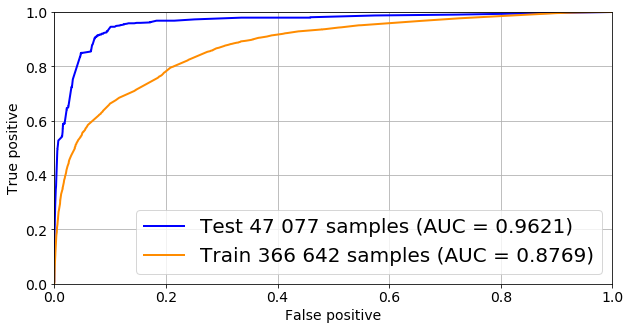

In [28]:
fig = plt.figure(figsize=(10, 5))
fig.patch.set_facecolor('white')
mpl.rcParams['font.size'] = 14
# plt.title("Рис. 9. ROC-кривые на временном тестовом сэмпле")

plot_roc_curve(y_test, y_test_pred, 'blue', 'Test')
plot_roc_curve(y_train, y_train_pred, 'darkorange', 'Train')

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


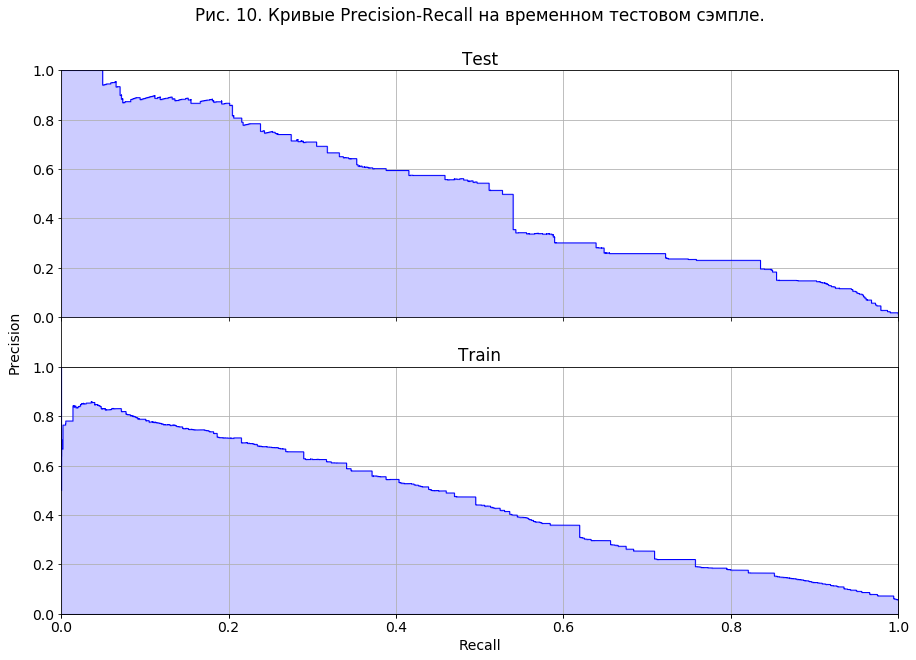

In [29]:
fig = plt.figure(figsize=[15, 10])
fig.patch.set_facecolor('white')
plt.title("Рис. 10. Кривые Precision-Recall на временном тестовом сэмпле.", y=1.08)
mpl.rcParams['font.size'] = 14

ax = plt.axes()
ax.set_yticks([])
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')
ax.yaxis.labelpad = 40

plot_precision_recall(fig, y_test, y_test_pred, 'Test', 1, 2)
plot_precision_recall(fig, y_train, y_train_pred, 'Train', 2, 2)

Результаты на тесте получились лучше, чем на трейне. Есть предположение, что это происходит из-за неравномерного содержания целевых событий в тесте и трейне. Для того, чтобы это проверить, нужно попробовать предсказать целевые события по периоду, где доля целевых событий в тестовой выборке будет значительно выше, чем в трейновой.

### 5. Временной сэмпл для июня
Для того, чтобы объяснить тот факт, что предсказания по тесту лучше, чем по трейну, попробуем сделать предсказание для июня, т.к. в июне конверсия клиентов в несколько раз выше, чем в ноябре.

### 5.1 Формируем трейн и тест

In [30]:
days_for_payment = 30
test_size_in_days = 30

# определяем граничные даты тестового интервала
test_begin_date = datetime.datetime(2017, 6, 15)
test_end_date = test_begin_date + datetime.timedelta(days=test_size_in_days)
print('Train begins ends on', test_begin_date)
print('Test begins on', test_begin_date, 'and ends on', test_end_date)

Train begins ends on 2017-06-15 00:00:00
Test begins on 2017-06-15 00:00:00 and ends on 2017-07-15 00:00:00


In [31]:
target_column = 't_column'
X_new = copy_dataset_and_create_target_variable(metabase_unload, target_column, days_for_payment)
X_test = X_new[(X_new["sign_up_date"] >= test_begin_date) & (X_new["sign_up_date"] < test_end_date)]
X_train = X_new[X_new["sign_up_date"] < test_begin_date]

In [32]:
print('Train sample size: ', len(X_train.index))
print('Target column distribution:')
print(X_train[target_column].value_counts(dropna=False, normalize=True))
print(X_train[target_column].value_counts(dropna=False, normalize=False))
print('')
print('Test sample size: ', len(X_test.index))
print('Target column distribution:')
print(X_test[target_column].value_counts(dropna=False, normalize=True))
print(X_test[target_column].value_counts(dropna=False, normalize=False))

Train sample size:  143025
Target column distribution:
0    0.941961
1    0.058039
Name: t_column, dtype: float64
0    134724
1      8301
Name: t_column, dtype: int64

Test sample size:  12158
Target column distribution:
0    0.855157
1    0.144843
Name: t_column, dtype: float64
0    10397
1     1761
Name: t_column, dtype: int64


### 5.2. Обучаем модель и предсказываем

In [33]:
y_train = X_train[target_column]
y_test = X_test[target_column]

classifier = xgb.XGBClassifier()

model_time = Model(target_column, woe_columns, category_columns, columns_to_drop, classifier)
model_time.fit(X_train, y_train)

y_test_pred = model_time.predict_proba(X_test)
y_train_pred = model_time.predict_proba(X_train)

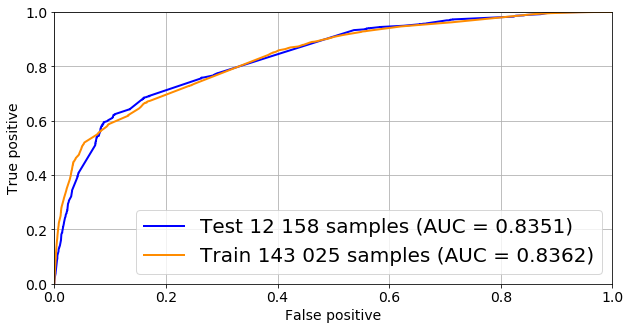

In [34]:
fig = plt.figure(figsize=(10, 5))
fig.patch.set_facecolor('white')
mpl.rcParams['font.size'] = 14
# plt.title("Рис. 11. ROC-кривые на временном тестовом сэмпле")

plot_roc_curve(y_test, y_test_pred, 'blue', 'Test')
plot_roc_curve(y_train, y_train_pred, 'darkorange', 'Train')

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


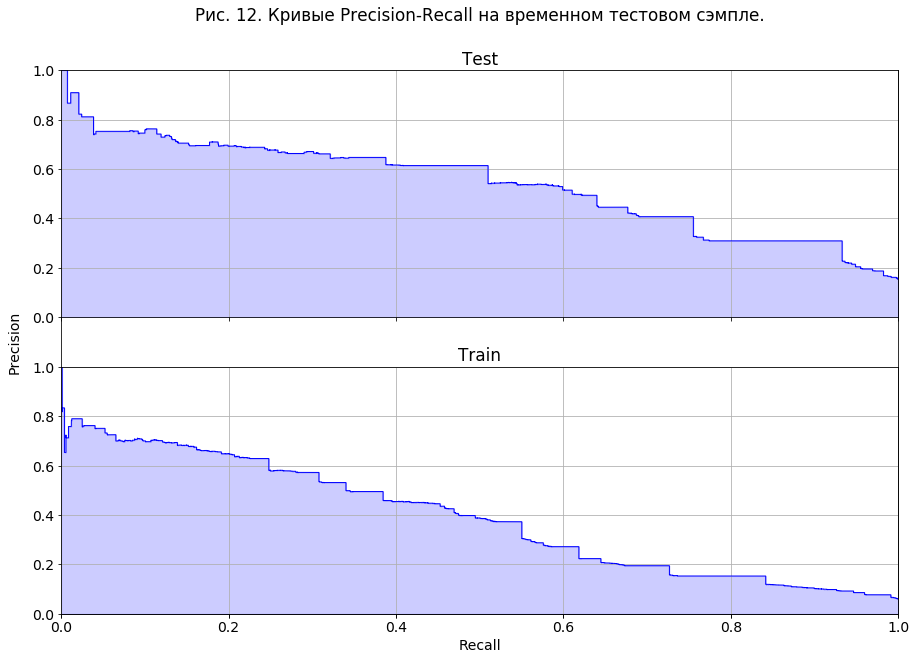

In [35]:
fig = plt.figure(figsize=[15, 10])
fig.patch.set_facecolor('white')
plt.title("Рис. 12. Кривые Precision-Recall на временном тестовом сэмпле.", y=1.08)
mpl.rcParams['font.size'] = 14

ax = plt.axes()
ax.set_yticks([])
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')
ax.yaxis.labelpad = 40

plot_precision_recall(fig, y_test, y_test_pred, 'Test', 1, 2)
plot_precision_recall(fig, y_train, y_train_pred, 'Train', 2, 2)

## 6. Предскажем возможные оплаты от клиентов, зарегистрировавшихся вчера

In [36]:
# определяем граничные даты тестового интервала
max_reg_date = metabase_unload["sign_up_date"].max()
test_begin_date = max_reg_date - datetime.timedelta(days=1)

In [37]:
print(max_reg_date)
print(test_begin_date)

2017-12-14 16:55:05.978363
2017-12-13 16:55:05.978363


In [38]:
target_column = 't_column'
X_new = copy_dataset_and_create_target_variable(metabase_unload, target_column, 6)
X_test = X_new[(X_new["sign_up_date"] >= test_begin_date)]
X_train = X_new[X_new["sign_up_date"] < test_begin_date]

In [39]:
print('Train sample size: ', len(X_train.index))
print('Target column distribution:')
print(X_train[target_column].value_counts(dropna=False, normalize=True))

Train sample size:  508821
Target column distribution:
0    0.963877
1    0.036123
Name: t_column, dtype: float64


In [40]:
print('Test sample size: ', len(X_test.index))
print('Target column distribution:')
print(X_test[target_column].value_counts(dropna=False, normalize=True))

Test sample size:  2186
Target column distribution:
0    0.982159
1    0.017841
Name: t_column, dtype: float64


In [42]:
y_train = X_train[target_column]
y_test = X_test[target_column]

classifier = xgb.XGBClassifier()

model_time = Model(target_column, woe_columns, category_columns, columns_to_drop, classifier)
model_time.fit(X_train, y_train)

y_test_pred = model_time.predict_proba(X_test)
y_train_pred = model_time.predict_proba(X_train)

In [43]:
data = {'user_id': list(X_test['user_id']), 'paid': list(y_test), 'rank': list(y_test_pred[:, 1])}
clients_separated = pd.DataFrame(data)
clients_separated[clients_separated['paid'] == 0].sort_values('rank', ascending=False)[['user_id']]\
    .to_csv('results.csv', index=False)

In [44]:
clients_separated.sort_values('rank', ascending=False).to_csv('results.csv', index=False)